# TSP QAOA VQE

In [1]:
# qiskit_ibm_runtime v0.14.2
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import SamplingVQE, QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
import networkx as nx
import matplotlib.pyplot as plt
import random
from docplex.mp.model import Model
from utils.utils import get_feasibility_ratio, get_info, get_cost_ratio, get_best_ratio
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeOsaka
# We need to use V1 because qiskit people deprecate stuff without updating their libraries and documentation
from qiskit_ibm_runtime import SamplerV1 as QSampler
from qiskit_key import get_key

service = get_key()

## Create graph

In [2]:
class Graph:
    def __init__(self, n_nodes: int) -> None:
        self.n_nodes = n_nodes
        self.__create_graph()

    def __create_graph(self) -> None:
        self.graph = nx.Graph()
        self.graph.add_nodes_from(range(self.n_nodes))
        for i in range(self.n_nodes):
            for j in range(self.n_nodes):
                if i == j:
                    continue
                # weight = W_i,j
                self.graph.add_edge(i, j, weight=random.randrange(2, 20))

    def plot_graph(self) -> None:
        pos = nx.circular_layout(self.graph)
        nx.draw_networkx_nodes(self.graph, pos)
        nx.draw_networkx_edges(self.graph, pos)
        nx.draw_networkx_labels(self.graph, pos)
        nx.draw_networkx_edge_labels(self.graph, pos, nx.get_edge_attributes(self.graph, 'weight'), font_size=10,
                                     font_color="b")
        plt.plot()

    def get_edge_weight(self, node1: int, node2: int) -> int:
        return self.graph.edges[node1, node2]['weight']


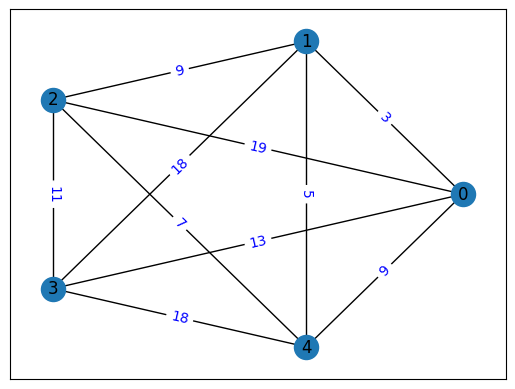

In [3]:
graph = Graph(5)
graph.plot_graph()

In [4]:
def find_optimal(graph: nx.Graph) -> int:
    import itertools
    all_paths = []
    permutations = list(itertools.permutations([i for i in range(1, graph.number_of_nodes())]))
    for p in permutations:
        path = list(p)
        path.insert(0, 0)
        path.append(0)
        all_paths.append(path)

    min_cost = float("inf")
    for path in all_paths:
        try:
            cost = sum(graph[i][j]["weight"] for i, j in nx.utils.pairwise(path))
            if cost < min_cost:
                print(path)
                min_cost = cost
        except KeyError:
            continue

    return min_cost

optimal_cost = find_optimal(graph.graph)
print(optimal_cost)

[0, 1, 2, 3, 4, 0]
[0, 1, 3, 2, 4, 0]
[0, 1, 4, 2, 3, 0]
39


## Create model 

In [5]:
def create_variables(n: int, mdl: Model) -> dict:
    x = {}
    for i in range(1, n):
        for t in range(1, n):
            x[(i, t)] = mdl.binary_var(name=f"x_{i},{t}")
    return x


# 8
def cost_function(n: int, vars: dict, graph: Graph, mdl: Model) -> float:
    v = 0
    for i in range(1, n):
        for j in range(1, n):
            if i == j:
                continue
            v += graph.get_edge_weight(i, j) * mdl.sum(vars[(i, t)] * vars[(j, t + 1)] for t in range(1, n - 1))

    v += mdl.sum([graph.get_edge_weight(0, i) * (vars[(i, 1)] + vars[(i, n - 1)]) for i in range(1, n)])
    return v


def constraints(n: int, vars: dict, mdl: Model) -> None:
    # multiple city at same time constraint
    for t in range(1, n):
        mdl.add_constraint(
            mdl.sum(vars[(i, t)] for i in range(1, n)) == 1,
            f"t_{t}"
        )
    # revisit city constrain
    for i in range(1, n):
        mdl.add_constraint(
            mdl.sum(vars[(i, t)] for t in range(1, n)) == 1,
            f"i_{i}"
        )


def create_model(graph: Graph) -> QuadraticProgram:
    mdl = Model("TSP")
    vars = create_variables(graph.n_nodes, mdl)
    mdl.minimize(cost_function(graph.n_nodes, vars, graph, mdl))
    constraints(graph.n_nodes, vars, mdl)

    return from_docplex_mp(mdl)


In [6]:
qp = create_model(graph)

print(qp.prettyprint())

Problem name: TSP

Minimize
  9*x_1,1*x_2,2 + 18*x_1,1*x_3,2 + 5*x_1,1*x_4,2 + 9*x_1,2*x_2,1 + 9*x_1,2*x_2,3
  + 18*x_1,2*x_3,1 + 18*x_1,2*x_3,3 + 5*x_1,2*x_4,1 + 5*x_1,2*x_4,3
  + 9*x_1,3*x_2,2 + 9*x_1,3*x_2,4 + 18*x_1,3*x_3,2 + 18*x_1,3*x_3,4
  + 5*x_1,3*x_4,2 + 5*x_1,3*x_4,4 + 9*x_1,4*x_2,3 + 18*x_1,4*x_3,3
  + 5*x_1,4*x_4,3 + 11*x_2,1*x_3,2 + 7*x_2,1*x_4,2 + 11*x_2,2*x_3,1
  + 11*x_2,2*x_3,3 + 7*x_2,2*x_4,1 + 7*x_2,2*x_4,3 + 11*x_2,3*x_3,2
  + 11*x_2,3*x_3,4 + 7*x_2,3*x_4,2 + 7*x_2,3*x_4,4 + 11*x_2,4*x_3,3
  + 7*x_2,4*x_4,3 + 18*x_3,1*x_4,2 + 18*x_3,2*x_4,1 + 18*x_3,2*x_4,3
  + 18*x_3,3*x_4,2 + 18*x_3,3*x_4,4 + 18*x_3,4*x_4,3 + 3*x_1,1 + 3*x_1,4
  + 19*x_2,1 + 19*x_2,4 + 13*x_3,1 + 13*x_3,4 + 9*x_4,1 + 9*x_4,4

Subject to
  Linear constraints (8)
    x_1,1 + x_2,1 + x_3,1 + x_4,1 == 1  't_1'
    x_1,2 + x_2,2 + x_3,2 + x_4,2 == 1  't_2'
    x_1,3 + x_2,3 + x_3,3 + x_4,3 == 1  't_3'
    x_1,4 + x_2,4 + x_3,4 + x_4,4 == 1  't_4'
    x_1,1 + x_1,2 + x_1,3 + x_1,4 == 1  'i_1'
    x_2,1

### Convert to QUBO

In [7]:
from qiskit_optimization.converters import QuadraticProgramToQubo

# conversao do qubo nao esta aplicando as restricoes?
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

In [8]:
print(qubo.prettyprint())

Problem name: TSP

Minimize
  994*x_1,1^2 + 994*x_1,1*x_1,2 + 994*x_1,1*x_1,3 + 994*x_1,1*x_1,4
  + 994*x_1,1*x_2,1 + 9*x_1,1*x_2,2 + 994*x_1,1*x_3,1 + 18*x_1,1*x_3,2
  + 994*x_1,1*x_4,1 + 5*x_1,1*x_4,2 + 994*x_1,2^2 + 994*x_1,2*x_1,3
  + 994*x_1,2*x_1,4 + 9*x_1,2*x_2,1 + 994*x_1,2*x_2,2 + 9*x_1,2*x_2,3
  + 18*x_1,2*x_3,1 + 994*x_1,2*x_3,2 + 18*x_1,2*x_3,3 + 5*x_1,2*x_4,1
  + 994*x_1,2*x_4,2 + 5*x_1,2*x_4,3 + 994*x_1,3^2 + 994*x_1,3*x_1,4
  + 9*x_1,3*x_2,2 + 994*x_1,3*x_2,3 + 9*x_1,3*x_2,4 + 18*x_1,3*x_3,2
  + 994*x_1,3*x_3,3 + 18*x_1,3*x_3,4 + 5*x_1,3*x_4,2 + 994*x_1,3*x_4,3
  + 5*x_1,3*x_4,4 + 994*x_1,4^2 + 9*x_1,4*x_2,3 + 994*x_1,4*x_2,4
  + 18*x_1,4*x_3,3 + 994*x_1,4*x_3,4 + 5*x_1,4*x_4,3 + 994*x_1,4*x_4,4
  + 994*x_2,1^2 + 994*x_2,1*x_2,2 + 994*x_2,1*x_2,3 + 994*x_2,1*x_2,4
  + 994*x_2,1*x_3,1 + 11*x_2,1*x_3,2 + 994*x_2,1*x_4,1 + 7*x_2,1*x_4,2
  + 994*x_2,2^2 + 994*x_2,2*x_2,3 + 994*x_2,2*x_2,4 + 11*x_2,2*x_3,1
  + 994*x_2,2*x_3,2 + 11*x_2,2*x_3,3 + 7*x_2,2*x_4,1 + 994*x_2,2*x_4,2

## Execution

In [9]:
def plot_result_bitstring(bitstring, qp):
    # bitstring start from right to left
    print(f"Bitstring: {bitstring}")
    bitstr_inv = [int(bitstring[-1 - i]) for i in range(len(bitstring))]
    print(f"Bitstring invert: {bitstr_inv}")
    final_path = []
    for key, index in qp.variables_index.items():
        if bitstr_inv[index] == 1:
            final_path.append(key)
    final_path = sorted(final_path, key=lambda x: int(x[-1]))
    print(final_path)
    final_path = [int(x[2]) for x in final_path]

    weight = (
            graph.get_edge_weight(0, final_path[0]) +
            sum([graph.get_edge_weight(final_path[i], final_path[i + 1]) for i in range(len(final_path) - 1)]) +
            graph.get_edge_weight(final_path[-1], 0)
    )
    print(f"Total weight: {weight}")

    plot_graph = nx.DiGraph()
    plot_graph.add_edges_from(
        [(0, final_path[0])] +
        [(final_path[i], final_path[i + 1]) for i in range(len(final_path) - 1)] +
        [(final_path[-1], 0)]
    )

    nx.draw_circular(plot_graph, with_labels=True)


In [10]:
# simple sampler
sampler = Sampler()

# create simulator with noise information from ibmq_osaka
aer_sim = AerSimulator().from_backend(FakeOsaka())
noisy_sampler = QSampler(backend=aer_sim)

/tmp/ipykernel_978/849402328.py:6: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  noisy_sampler = QSampler(backend=aer_sim)


### QAOA

In [11]:
algorithm_globals.random_seed = 12345
qaoa_mes = QAOA(sampler=noisy_sampler, optimizer=COBYLA(), initial_point=[0.0, 1.0])

qaoa = MinimumEigenOptimizer(qaoa_mes)
qaoa_result = qaoa.solve(qubo)

In [12]:
qaoa_result.samples

[SolutionSample(x=array([1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.]), fval=65.0, probability=0.00025, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), fval=65.0, probability=0.00025, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), fval=73.0, probability=0.00025, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), fval=1022.0, probability=0.00025, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), fval=1024.0, probability=0.00025, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), fval=1024.0, probability=0.0005, status=<OptimizationRe

In [13]:
qaoa_result.fval

65.0

In [14]:
print(qaoa_result.prettyprint())

objective function value: 65.0
variable values: x_1,1=1.0, x_1,2=0.0, x_1,3=0.0, x_1,4=0.0, x_2,1=0.0, x_2,2=0.0, x_2,3=0.0, x_2,4=1.0, x_3,1=0.0, x_3,2=1.0, x_3,3=0.0, x_3,4=0.0, x_4,1=0.0, x_4,2=0.0, x_4,3=1.0, x_4,4=0.0
status: SUCCESS


In [15]:
# plot_result_bitstring(qaoa_result.min_eigen_solver_result.best_measurement['bitstring'], qp)

#### Metrics

In [16]:
import multiprocessing as mp


def process_samples(samples, qp):
    pool = mp.Pool(mp.cpu_count())
    processes = [pool.apply_async(get_info, args=(s, qp)) for s in samples]
    result = [p.get() for p in processes]
    return result

In [17]:
# probabilidades são baixas mesmo?
samples_list = process_samples(qaoa_result.samples, qp)

feasibility_ratio = get_feasibility_ratio(samples_list)
cost_ratio = get_cost_ratio(samples_list, optimal_cost)
best_ratio = get_best_ratio(qaoa_result.fval, optimal_cost)
print(feasibility_ratio)
print(cost_ratio)
print(best_ratio)

0.0008176614881439084
0.5763546798029556
0.6


### VQE

In [18]:
from qiskit_algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5)
optimizer = SPSA()

In [19]:
vqe = SamplingVQE(sampler=noisy_sampler, ansatz=ansatz, optimizer=optimizer)

In [20]:
optimizer = MinimumEigenOptimizer(vqe)
vqe_result = optimizer.solve(qubo)

In [21]:
vqe_result.samples

[SolutionSample(x=array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), fval=50.0, probability=0.0005, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.]), fval=56.0, probability=0.0015, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.]), fval=62.0, probability=0.0005, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), fval=65.0, probability=0.0005, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.]), fval=73.0, probability=0.00025, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), fval=1015.0, probability=0.0005, status=<OptimizationResultStat

In [22]:
print(vqe_result.prettyprint())

objective function value: 50.0
variable values: x_1,1=1.0, x_1,2=0.0, x_1,3=0.0, x_1,4=0.0, x_2,1=0.0, x_2,2=1.0, x_2,3=0.0, x_2,4=0.0, x_3,1=0.0, x_3,2=0.0, x_3,3=1.0, x_3,4=0.0, x_4,1=0.0, x_4,2=0.0, x_4,3=0.0, x_4,4=1.0
status: SUCCESS


In [23]:
# plot_result_bitstring(vqe_result.min_eigen_solver_result.best_measurement['bitstring'], qp)

#### Metrics

In [24]:
samples_list = process_samples(vqe_result.samples, qp)

feasibility_ratio = get_feasibility_ratio(samples_list)
cost_ratio = get_cost_ratio(samples_list, optimal_cost)
best_ratio = get_best_ratio(vqe_result.fval, optimal_cost)
print(feasibility_ratio)
print(cost_ratio)
print(best_ratio)

0.0028636884306987398
0.6372549019607843
0.78
